# Transformers for Coxeter Group Word Problem

## Abstract

The word problem is one of historical problems in the computational group theory. In this project, I propose an approximated solution for this problem in the context of Coxeter group using GRU based encoder-decoder model. I introduce the theoretical background of the word computational problem and structure of the encoder-decoder model. The model reaches the accuracy of 0.8 on the validation set on average.

To improve the generating result, I attach the attention mechanism to the model. The attention mechanism allows the model to focus on different parts of the input sequence when generating the output sequence. The model with attention mechanism reaches the accuracy of 0.9 on the validation set on average.

## Backgrounds

In mathematics, a group is a set $G$ with a binary operation $* : G \times G \to G$. The operation is associative and the group has an identity $e$ along with an inverse element $a^{-1}$ for each $a \in G$. Many familiar objects such as integers, matrices and rotations of geometry shapes.

The modern group theory was first developed by Galois, arising from his effort in finding solutions to high-order algebraic equations. Nowadays, thanks to its proper abstraction for symmetry, group theory is finding its application across many fields, especially physics, computer science and machine learning. Among all of such applications, sometimes we focus on the theoretical derivation, but there are always occasions where we need to do actual computations in groups, either to get instincts or to obtain potential patterns. 

One of the most important group is Coxeter group, which is a group generated by reflections across hyperplanes [2, 4]. It is a generalization of the symmetric group and is closely related to many other groups, including Weyl group, braid group and Artin group. Coxeter group is particularly important in the theory of reflection groups and hyperbolic geometry.

The word problem is a fundamental problem in the computational group theory, which asks whether two words represent the same element in a group. It is an undecidable problem in general, but in some groups, it is NP-complete. In Coxeter group, the word problem is known to be decidable, but it is still hard to find an efficient algorithm to solve it. If we can decide the unique normal form of a word, we can solve the word problem.

## Basic Concepts

Heuristically, we have a group $G$ with a generating set $S$, that is to say any element $a \in G$ can be written in the form $$ a = s_1 s_2 \cdots s_k. $$. There are also equivalence called relations. For example, in the symmetric group $S_3$, we have generaters $(12), (23)$ relations such as $(12)(23)(12) = (23)(12)(23)$. A reduced word is a word that cannot be simplified by the relations. A word can correspond to multiple reduced words. The reduced word of a word that is lexically smallest is called the normal form of the word. Hence, we have a one-to-one correspondence between normal forms and elements in the group.

In group theory, we use linguistic terminology to specify the representation of group elements, this is also where inspires me to apply modern language model. Here I will follow the conventions in book [1].

Formally, an alphabet $S$ means a finite set of symbols, where the element of $S$ is called a letter. A string is a finite sequence of letters, which is to give $n \in \mathbb{N}$, along with a mapping $w : [n] \to S$, which is represented by list structure. A word over $S$ is a string over an alphabet $S \cup S^{-1}$. Examples will be given in the following section. A language is a set of words over $S$. 

In this project, I will propose an approximated solution for the decision of normal form in Coxeter group using generative models. The idea is to use an Encoder-decoder model with attention machanism to learn the mapping between words and normal forms, and then use the model to predict the normal form of a word. Main idea is inspired by the translation model in machine translation [5].

## References
1. Epstein, D. B. A., Cannon (1992). Word processing in groups. Jones & Bartlett Learning.
2. Humphreys, J. E. (1992). Reflection groups and Coxeter groups. Cambridge university press.
3. Geck (2012). PyCox: computing with (finite) Coxeter groups and Iwahori–Hecke algebras
4. Bjorner, A., Brenti, F. (2005). Combinatorics of Coxeter groups. Springer Science & Business Media.
5. Bahdanau, D., Cho, K., Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.

## Examples

As we need to generate the data for training, we will demonstrate the existing algorithm for the problem. Here we will use the PyCox package [3] to generate the data, which is the latest Python reimplementation of the Coxeter group algorithms from GAP system.

In PyCox, normal form computation is implemented by the geometric representation for Coxeter group, which relies on a heavy derivation of combinatorial theory.

In [7]:
import PyCox.chv1r6180 as chv1r6180

                                                                     
  ###################################################################
  ##  A PYTHON VERSION OF CHEVIE-GAP FOR (FINITE) COXETER GROUPS   ##
  ##      (by Meinolf Geck,  version 1r6p180, 27 Jan 2014)         ##
  ##                                                               ##
  ##  To get started type "help(coxeter)" or "help(allfunctions)"; ##
  ##  see also http://dx.doi.org/10.1112/S1461157012001064.        ##
  ##  For notes about this version type  "versioninfo(1.6)".       ##
  ##  Check www.mathematik.uni-stuttgart.de/~geckmf for updates.   ##
  ##                                                               ##
  ##  Import into "sage" (4.7 or higher, www.sagemath.org) works.  ##
  ##                                                               ##
  ##       The proposed name for this module is "PyCox".           ##
  ##                  All comments welcome!                        ##
  ##################

We will take S4 as an example, which corresponds to Coxeter type A4. The generators are $s_1, s_2, s_3$ and the relations are $s_1^2 = s_2^2 = s_3^2 = 1, (s_1s_2)^3 = (s_2s_3)^3 = 1$. 

In [8]:

W = chv1r6180.coxeter("A", 4)
wd = [0, 1, 3, 2, 2, 1, 2]
rwd = W.reducedword(wd, W)
print(f"{wd} -> {rwd}")

wd = [0, 2, 1, 2, 3, 1, 2]
rwd = W.reducedword(wd, W)
print(f"{wd} -> {rwd}")

wd = [3, 1, 2, 0, 2, 1]
rwd = W.reducedword(wd, W)
print(f"{wd} -> {rwd}")

[0, 1, 3, 2, 2, 1, 2] -> [0, 3, 2]
[0, 2, 1, 2, 3, 1, 2] -> [0, 1, 2, 3, 2]
[3, 1, 2, 0, 2, 1] -> [0, 1, 0, 3]


This is what we need for the dataset. For a certain type of finite Coxeter group, if we view language of word and reduced words as a vocabulary, and each word as a sentence, this mapping is then identical to the machine translation problem. We can then use the encoder-decoder model to learn the mapping.

In [9]:
from __future__ import unicode_literals, print_function, division
from io import open
from pathlib import Path
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from tqdm import tqdm, trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We will need a class for the aggregation of vocabulary. Identity element is also included in the vocabulary.

In [10]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [11]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?0-9]+", r" ", s)
    return s.strip()

As a translation task, our data and target will be stored in the form of pairs. The data is pre-generated by PyCox. The script for generation is written in a separate file `word_gen.py` in the folder, and the generated data is stored in the folder `data`.

In [12]:
def readLangs(lang1, lang2, reverse=False, path='data'):
    print("Reading lines...")

    # Read the file and split into lines
    path = Path(path) / f'{lang1}-{lang2}.txt'
    lines = open(path, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

As the limitation of local computation, we will consider the case of Coxeter group of type H4, which is a group of order 14400.

In [13]:
MAX_LENGTH = 10 
eng_prefixes = ("")

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [14]:
def prepareData(lang1, lang2, reverse=False, path='data'):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse, path)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('wd', 'rwd', False, 'data/typeH3/')
print(random.choice(pairs))

Reading lines...
Read 8495 sentence pairs
Trimmed to 1578 sentence pairs
Counting words...
Counted words:
wd 5
rwd 6
['0 0 1 0 1 2 0 1 1', '1 0 1 0 2']


## Build the model

The model will be composed of an encoder and a decoder.

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=n_layers)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

The encoder is a simple gated recurrent unit (GRU) with an embedding layer. Each unit of the encoder will take a word as input and output a hidden state, which is demonstrated in the  The hidden state will be passed to the decoder.
<center><img src="Images/GRU.png" width=600/></center>

First, instead of one-hot encoding, here word-embedding technique is used to convert the word into a dense vector, which is good for manipulating `<SOS>` and `<EOS>` tokens in this case. The embedding layer is followed by a GRU layer, which is a type of recurrent neural network (RNN) that is more efficient than the traditional RNN. Finally, a dropout layer is added to prevent overfitting.

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=n_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

The decoder structure is also a GRU with an embedding layer. However, it is more complicated from 2 perspectives. 

First, it needs to process the hidden layer from the encoder, which is the context vector. Second, it uses a technique called "teacher forcing" where the next input is the actual target output. If no target tensor is provided, it uses the decoder's own prediction as the next input. Finally, it concatenates all the outputs, applies a `log_softmax` function to the outputs, and returns the outputs along with the final hidden state.


## Training and validation

To start training, we will first load the data and target tensors. In this period, we need lots of helper functions.

In [17]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def sentenceFromTensor(lang, tensor):
    words = []
    for idx in tensor.squeeze():
        word = lang.index2word[idx.item()]
        if word == 'EOS':
            break
        words.append(word)
    return ' '.join(words)

def pairFromTensor(input_tensor, target_tensor):
    input_sentence = sentenceFromTensor(input_lang, input_tensor)
    target_sentence = sentenceFromTensor(output_lang, target_tensor)
    return (input_sentence, target_sentence)

def get_dataloader(batch_size, path='data'):
    """Get dataloaders from raw translation data
    """
    input_lang, output_lang, pairs = prepareData('wd', 'rwd', False, path)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_data, val_data = torch.utils.data.random_split(train_data, [int(0.8 * n), n - int(0.8 * n)])
    train_sampler = RandomSampler(train_data)
    val_sampler = RandomSampler(val_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader, val_dataloader

Then, by defining the loss function and optimizer, we can start training the model. The training process will follow a torch convention, where we will first zero the gradients, feed the input and target tensors to the model, and calculate the loss for one epoch in `train_epoch`. Then we iterate all the epochs in `train` function.

In [18]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Now we include some functions to record the training time.

In [19]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [72]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    return plot_losses

We will also need a plot functions.

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Functions for validations are povided. 

First, we have a semantic validation `evaluateRandomly`, which is to check if the model can predict the normal form of a word. Second, we have a syntactic validation `evaluateFromDataloader`, which is to check if the model can predict the normal form of a word that is not in the training set.

In [22]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in trange(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluateFromDataloader(encoder, decoder, dataloader, show_output=False):
    accuracy = []
    for data in dataloader:
        input_tensor, target_tensor = data
        correct = 0
        for i in range(input_tensor.size(0)):
            input_sentence = sentenceFromTensor(input_lang, input_tensor[i])
            target_sentence = sentenceFromTensor(output_lang, target_tensor[i])
            # print('>', input_sentence)
            # print('=', target_sentence)
            output_words, _ = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
            output_sentence = ' '.join(output_words)
            output_sentence_no_eos = output_sentence.replace('<EOS>', '')
            if output_sentence_no_eos.strip() == target_sentence.strip():
                correct += 1
            else:
                if show_output:
                    print(f"predicted: {output_sentence_no_eos} \ntarget:    {target_sentence}")
            # print('<', output_sentence)
            # print('')
        accuracy.append(correct / input_tensor.size(0))
    
    print(f'Accuracy: {100 * sum(accuracy)/len(accuracy)}%')

Finally, we can start the training process.

In [45]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader, val_dataloader = get_dataloader(batch_size, path='data/typeH3/')

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 8495 sentence pairs
Trimmed to 1578 sentence pairs
Counting words...
Counted words:
wd 5
rwd 6
0m 9s (- 2m 20s) (5 6%) 0.4104
0m 17s (- 2m 5s) (10 12%) 0.2039
0m 25s (- 1m 51s) (15 18%) 0.0593
0m 34s (- 1m 43s) (20 25%) 0.0199
0m 43s (- 1m 34s) (25 31%) 0.0108
0m 55s (- 1m 32s) (30 37%) 0.0064
1m 4s (- 1m 22s) (35 43%) 0.0042
1m 14s (- 1m 14s) (40 50%) 0.0041
1m 22s (- 1m 3s) (45 56%) 0.0011
1m 30s (- 0m 54s) (50 62%) 0.0007
1m 38s (- 0m 44s) (55 68%) 0.0005
1m 47s (- 0m 35s) (60 75%) 0.0003
1m 56s (- 0m 26s) (65 81%) 0.0075
2m 3s (- 0m 17s) (70 87%) 0.0018
2m 14s (- 0m 8s) (75 93%) 0.0003
2m 22s (- 0m 0s) (80 100%) 0.0002


In [46]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder, n=4)

100%|██████████| 4/4 [00:00<00:00, 22.99it/s]

> 2 2 2 1 1
= 2
< 2 <EOS>

> 2 1 0 0 0 0
= 2 1
< 1 2 1 <EOS>

> 2 1 2 0 2 2 0
= 1 2 1
< 1 2 1 <EOS>

> 1 1 0 0 1
= 1
< 1 <EOS>



In [47]:
encoder.eval()
decoder.eval()
evaluateFromDataloader(encoder, decoder, train_dataloader)
evaluateFromDataloader(encoder, decoder, val_dataloader, show_output=True)

Accuracy: 77.64508928571429%
predicted:  
target:    e
predicted: 1 2 1  
target:    2 1
predicted: 0 1 2 1 0  
target:    0 2 1 0
predicted: 1 0 1 2 1  
target:    1 0 2 1
predicted: 1 2 1  
target:    2 1
predicted: 1 2 1  
target:    2 1
predicted: 2 1 0 1 0  
target:    1 0 2 1 0 1 0
predicted: 1 2 1 0 1  
target:    2 1 0 1
predicted: 1 2 1  
target:    2 1
predicted: 0  
target:    0 2
predicted: 0 1 0 1 0 2  
target:    0 1 0 1 2
predicted: 2  
target:    e
predicted: 2  
target:    e
predicted: 1 2 1 0 1  
target:    2 1 0 1
predicted: 1 2 1 0 1  
target:    2 1 0 1
predicted: 0 1 2 1 0  
target:    0 2 1 0
predicted: 1 2 1  
target:    2 1
predicted: 0  
target:    0 2
predicted: 1 2 1  
target:    2 1
predicted: 2  
target:    e
predicted: 0  
target:    0 2
predicted: 0  
target:    0 2
predicted: 1 2 1  
target:    2 1
predicted: 2  
target:    e
predicted: 0  
target:    0 2
predicted: 0  
target:    0 2
predicted: 2 1 0  
target:    1 2 1 0
predicted: 1 2 1 0 1  
target: 

With only 1500 samples, the average accuracy on the validation set goes to around $0.8$(on average), with accuracy on train set over $0.9$(on average). We can conclude that the model has learned some information in the group and is able to predict the normal form of a word in Coxeter group with high accuracy. All the simple patterns is captured by the model, say the cancelation of two adjacent generators.
$$ s s \sim e, s_1 s_2 \sim s_2 s_1 $$

However, when we look into words where the model fails, we can see that on the one hand, the model fails to match the pattern with longer length, and on the other hand, the model seems to always make mistakes when the word is the identity of the group. 

## Improve the performance

To make the result better, we will try 2 different techniques correspondingly. First, the attention mechanism is added to the model to improve the generated result. Second, data argumentation will be carried out to increase the accuracy.

### Attention Mechanism

The attention mechanism is a key component in many modern neural network architectures, particularly in the field of Natural Language Processing (NLP). It was introduced to improve the performance of the Encoder-Decoder architecture on long sentences in sequence-to-sequence tasks like machine translation.

In the previous RNN Encoder-Decoder architecture, the encoder compresses all the input information into a fixed-length vector, and the decoder then expands this vector into the output sequence. This can lead to information loss when dealing with long sequences, as it's challenging to compress all necessary information of a long text into a fixed-size vector.

The attention mechanism addresses this issue by allowing the model to "focus" on different parts of the input sequence at each step of the output sequence. Instead of encoding the input sequence into a single fixed-length vector, the attention-equipped model creates **a set of "annotation" vectors**. When generating each word of the output sequence, the model uses the attention mechanism to create **a weighted sum** of these annotation vectors, thus forming a context vector for each output word. This context vector is then used to generate the output word.

<center><img src="Images/bahdanau.png" width=200/></center>

For this small scale model, Bahdanau Attention is usually a good choice. In the Bahdanau Attention mechanism, the attention weights (used to create the weighted sum of annotation vectors) are computed using **a feed-forward network with a single hidden layer**. The hidden state of the decoder and the annotation vector are used as inputs to this network.

The attention mechanism improves the model's ability to handle long sequences, leading to better performance on tasks like machine translation. It allows the model to "remember" important parts of the input sequence, even if they're far from the current position in the sequence, leading to more accurate and coherent outputs.

In [48]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

Now we use attention mechanism to re-train the model.

In [75]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader, val_dataloader = get_dataloader(batch_size, path='data/typeH3/')

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

losses = train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)


Reading lines...


Read 8495 sentence pairs
Trimmed to 1578 sentence pairs
Counting words...
Counted words:
wd 5
rwd 6
0m 14s (- 3m 34s) (5 6%) 0.3807
0m 31s (- 3m 42s) (10 12%) 0.1547
0m 48s (- 3m 31s) (15 18%) 0.0352
1m 5s (- 3m 16s) (20 25%) 0.0142
1m 18s (- 2m 53s) (25 31%) 0.0078
1m 36s (- 2m 40s) (30 37%) 0.0044
1m 49s (- 2m 21s) (35 43%) 0.0058
2m 6s (- 2m 6s) (40 50%) 0.0051
2m 20s (- 1m 49s) (45 56%) 0.0017
2m 33s (- 1m 31s) (50 62%) 0.0012
2m 44s (- 1m 14s) (55 68%) 0.0005
2m 59s (- 0m 59s) (60 75%) 0.0003
3m 14s (- 0m 44s) (65 81%) 0.0002
3m 29s (- 0m 29s) (70 87%) 0.0002
3m 42s (- 0m 14s) (75 93%) 0.0001
3m 58s (- 0m 0s) (80 100%) 0.0001


In [76]:
encoder.eval()
decoder.eval()
evaluateFromDataloader(encoder, decoder, train_dataloader)
evaluateFromDataloader(encoder, decoder, val_dataloader)

Accuracy: 98.57142857142858%
Accuracy: 97.14285714285714%


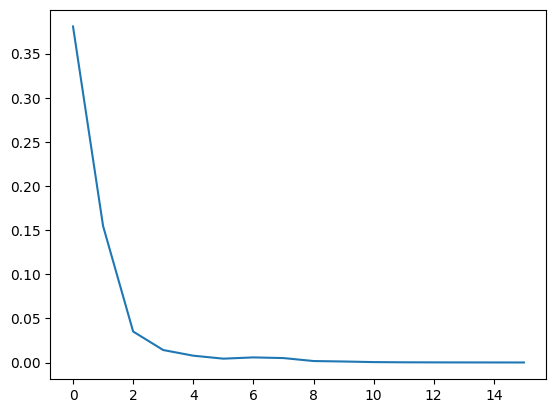

In [93]:
plt.plot(losses)
plt.show()

We can see that the model with attention mechanism has a better performance than the model without attention mechanism. The average accuracy on the validation set goes to around $0.9$(on average), with accuracy on train set over $0.95$(on average).

Loss curve is shown above, where the loss of the model with attention mechanism is lower and smoother than the model without attention mechanism.

### Visualize the attention

The attention based model is able to visualize the attention weights, and thus has a certain sense of interpretability. Such interpretability is important in the context of group theory or the fields of mathematics, as it can help us understand what the model has learned.

input = 0 1 0 1 2 1 2
output = 0 1 0 2 1 <EOS>


/tmp/ipykernel_275560/2146198274.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_275560/2146198274.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


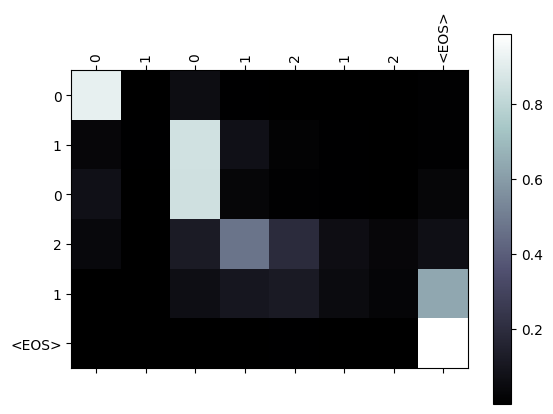

input = 1 1 2 1 2 0 2
output = 2 1 0 <EOS>


/tmp/ipykernel_275560/2146198274.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_275560/2146198274.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


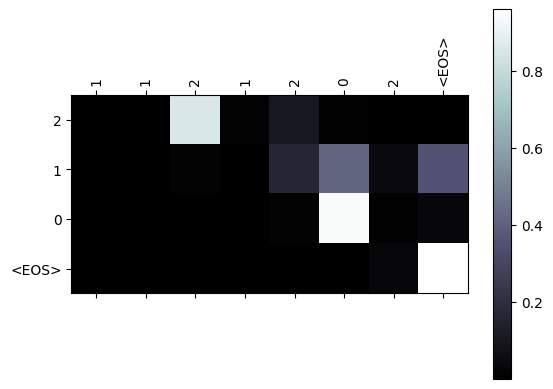

input = 0 0 1 1 2
output = 2 <EOS>


/tmp/ipykernel_275560/2146198274.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_275560/2146198274.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


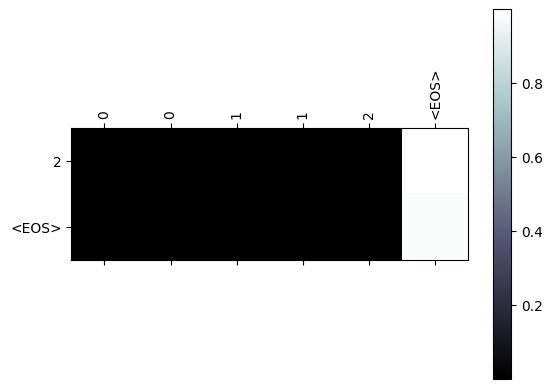

In [105]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('0 1 0 1 2 1 2')
evaluateAndShowAttention('1 1 2 1 2 0 2')
evaluateAndShowAttention('0 0 1 1 2')

By the attention weight diagram, we can see that in each time step of generation, the model is able to focus on the corresponding part of the input word, which is exactly the pattern of relations in most cases (the braid-move and nil-move pattern can refer to book [4] inference). 

However, there are also some cases I cannot understand why the model focuses on that part of the word, which turns to still reach the correct normal form.

## Table of other tests

The group $H_3$ that is demonstrated above is a group of order 120, with only 3 generators. We can also test the group $H_4$ that is a group of order 14400, with 4 generators. Other Coxeter groups such as classical groups $A_n, B_n, C_n, D_n$ can also be tested.

The main issue is the computation power. For a larger group (in the sense of order), it is generally harder to train the model, since it requirs larger dataset and longer lengths of words. To explore the capability of this model, I use the same script running on AWS EC2, with NVIDIA T4 of 32GB memory.

Test results are shown in the table
| Type  | rank | max length | train size | val accuracy |
| -------- | ------- | -------- | ------- | ------- |
| A  | 4 |  20  |   15568  |  3120  | 96.9% |
| H  | 4 |  20  |   15132  |  4123  | 97.2% |
| E  | 8 |  20  |   18000  |  2000  | 89.9% |

The datasets of these tests have already generated in the data folder.

## Conclusion

In this project, I propose an approximated solution for the word problem in Coxeter group using generative models. The project turns out to not follow my initial plan in the beginning, as is briefed in the Homework 2. I have tried simple encoder structure, such as RNN, GRU, LSTM for one layer, and they do not appear to have an acceptable performance. And it is not until I adopt the Seq2Seq model with attention mechanism that the model starts to learn the pattern in the Coxeter group, with surprisingly high accuracy. The gap between this transformer-like structure and the simple stack of RNN is so huge that I have to check thoroughly about each training procedure. I think the surprising result is by all means a good example of the power of modern neural network architecture.

Although word problems of Coxeter word has long been solved in 1990s, and mathematicians have made numerous efforts to simplify the computation, the result of project is still much impressive and inspiring for me. The elastic structure of network, that support varying lengths of both input and target, and the efficiency and interpretability that attention mechanism brings, are really a good match for many computational problems in the scope of pure mathematics.

The project treat word of Coxeter group as a language, and the normal form as a translation task to adapt the power of language model. In this way, classical objects such as polynomials, Young tableaus, and even the group itself, can be treated as a language with generalized set of languages. And those objects can also be benefited from recent advancement of natural language processing. This is only my primitive thoughts. And I will set out to explore more in the recent future.